In [23]:
import pandas as pd
from pymongo import MongoClient

import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np

In [12]:
# Set connection
client = MongoClient("mongodb://localhost:27017/")
db = client["bank"]
balances_collection = db["kaggle"]

# Load csv
accounts = pd.read_csv('sample/kaggle/accounts.csv')
transactions = pd.read_csv('sample/kaggle/transactions.csv')

In [13]:
# Create root
balances = {}

# Take users data from account.csv
for _, row in accounts.iterrows():
    acc_id = row["ACCOUNT_ID"] # User id
    open_date = 0
    initial_balance = round(float(row["INIT_BALANCE"]), 2)

    balances[acc_id] = [{"date": open_date,
                         "balance": initial_balance
                        }]
    
    if acc_id == 0: # Check
        print("first user must be 0 => ",str(acc_id))
        print("user 0 initial deposit must be 184.44 => ", initial_balance)

first user must be 0 =>  0
user 0 initial deposit must be 184.44 =>  184.44


In [14]:
print(len(transactions))

1323234


In [15]:
balances[0][0]

{'date': 0, 'balance': 184.44}

In [16]:
# Apply transactions to users' balances
transactions.sort_values(by="TX_ID")

# Track the last balance for each account
current_balances = {acct_id: balances[acct_id][0]["balance"] for acct_id in balances}

for i, (_, row) in enumerate(transactions.iterrows()):
    orig_acct = row["SENDER_ACCOUNT_ID"]
    bene_acct = row["RECEIVER_ACCOUNT_ID"]
    amount = row["TX_AMOUNT"]
    tx_type = row['TX_TYPE']
    date = row["TIMESTAMP"]

    if i == 0:
        print("first transaction must be from 6456 to 9069 => ", orig_acct, bene_acct)
    if i == 1323233: # check that read till the last transaction
        print("\nlast transaction must be from 545 to 2724 => ", orig_acct, bene_acct)

    if orig_acct in balances: # check that sender has a deposit
        last_balance = balances[orig_acct][-1]["balance"] # read balance from balances
        if tx_type in ['TRANSFER', 'WITHDRAWAL']: # all TRANSFER in the csv
            new_balance = last_balance - amount
        # elif tx_type == 'DEPOSIT':
        #    new_balance = last_balance + amount

        balances[orig_acct].append({"date": date, "balance": round(new_balance, 2)})
        if orig_acct == 0:
            print()
            print(row['TX_ID'])
            print(f"on date {date} user {orig_acct} send to {bene_acct} {amount} dollars")
            print(f"user {orig_acct} balance goes from {last_balance} to {new_balance}")
            print(balances[orig_acct])
            
    
    if bene_acct in balances: # check that receiver has a deposit
        last_balance = balances[bene_acct][-1]["balance"]
        if tx_type in ['TRANSFER', 'DEPOSIT']:
            new_balance = last_balance + amount
        # elif tx_type == 'WITHDRAWAL':
        #     new_balance = last_balance - amount

        balances[bene_acct].append({"date": date, "balance": round(new_balance, 2)})
        if bene_acct == 0:
            print()
            print(row['TX_ID'])
            print(f"on date {date} user {orig_acct} send to {bene_acct} {amount} dollars")
            print(f"user {bene_acct} balance goes from {last_balance} to {new_balance}")
            print(balances[bene_acct])
            

first transaction must be from 6456 to 9069 =>  6456 9069

last transaction must be from 545 to 2724 =>  545 2724


In [17]:
balances[0]

[{'date': 0, 'balance': 184.44}]

In [18]:
len(balances)

10000

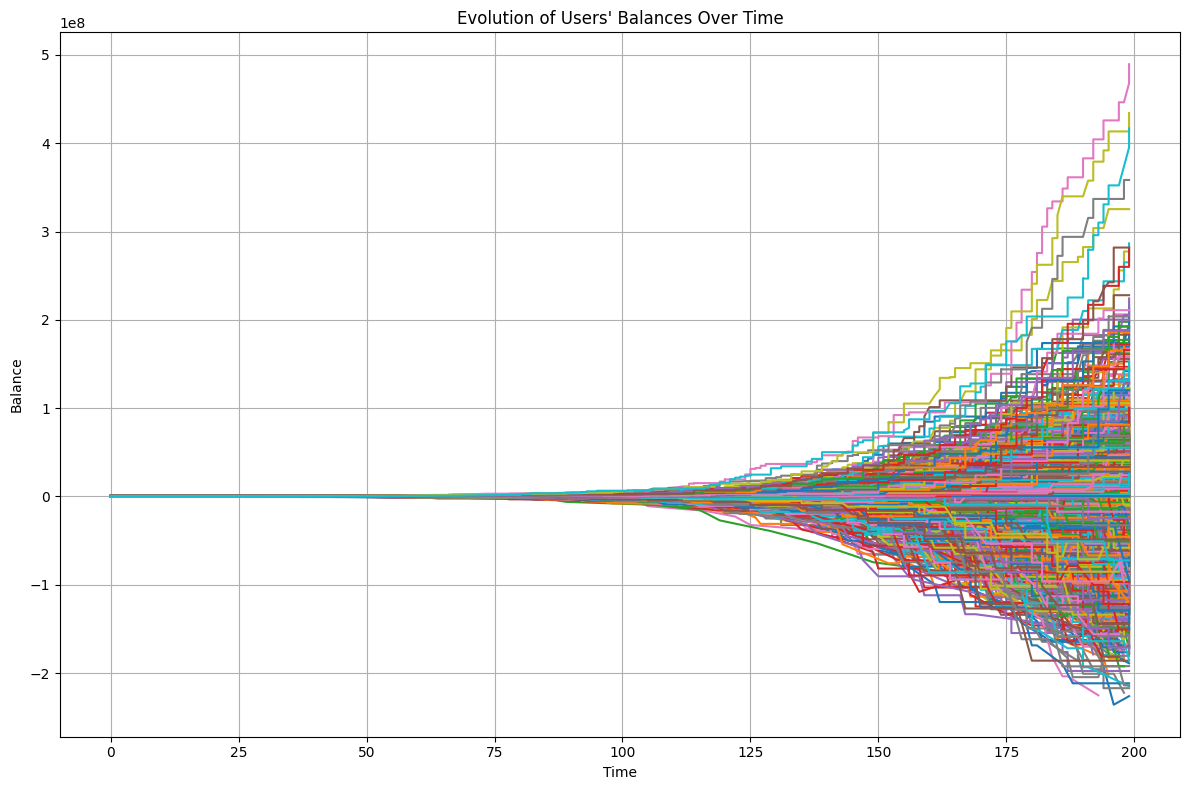

In [21]:
# Plot the balance evolution for each account
plt.figure(figsize=(12, 8))
for acct_id, account_data in balances.items():
    dates = [entry["date"] for entry in account_data]
    balance_values = [entry["balance"] for entry in account_data]
    plt.plot(dates, balance_values, label=f'Account {acct_id}')

plt.title('Evolution of Users\' Balances Over Time')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
for i, (acct_id, account_data) in enumerate(balances.items()):
    if i < 2:
        print(acct_id)
        print(account_data)
    

0
[{'date': 0, 'balance': 184.44}]
1
[{'date': 0, 'balance': 175.8}, {'date': 6, 'balance': 0.0}, {'date': 19, 'balance': -175.8}, {'date': 38, 'balance': -351.6}, {'date': 48, 'balance': -527.4}, {'date': 55, 'balance': -703.2}, {'date': 66, 'balance': -879.0}, {'date': 67, 'balance': -1054.8}, {'date': 76, 'balance': -1230.6}, {'date': 98, 'balance': -1406.4}, {'date': 117, 'balance': -1582.2}, {'date': 118, 'balance': -1758.0}, {'date': 135, 'balance': -1933.8}, {'date': 146, 'balance': -2109.6}, {'date': 148, 'balance': -2285.4}, {'date': 155, 'balance': -2461.2}, {'date': 156, 'balance': -2637.0}, {'date': 158, 'balance': -2812.8}, {'date': 159, 'balance': -2988.6}, {'date': 165, 'balance': -3164.4}, {'date': 175, 'balance': -3340.2}, {'date': 189, 'balance': -3516.0}, {'date': 195, 'balance': -3691.8}, {'date': 198, 'balance': -3867.6}, {'date': 199, 'balance': -4043.4}]


In [24]:
def is_monotonic(balance_values):
    return np.all(np.diff(balance_values) >= 0) or np.all(np.diff(balance_values) <= 0)

monotonic_accounts = []
non_monotonic_accounts = []

for acct_id, account_data in balances.items():
    account_data = sorted(account_data, key=lambda x: x["date"])  # sort by date (even they are sorted yet)
    # account_data is an array with [{date, balance} for each day for each user]

    balance_values = [entry["balance"] for entry in account_data]
    
    if is_monotonic(balance_values):
        monotonic_accounts.append(acct_id)
    else:
        non_monotonic_accounts.append(acct_id)

print(f"Monotonic Account: {len(monotonic_accounts)}")
print(f"Non Monotonic Account: {len(non_monotonic_accounts)}")
print(f"Percentage of monotonic account: {round(((len(monotonic_accounts) / len(balances)) * 100),2)}%")

assert len(balances) == (len(monotonic_accounts) + len(non_monotonic_accounts))

Monotonic Account: 74
Non Monotonic Account: 9926
Percentage of monotonic account: 0.74%


In [15]:
# import numpy as np
# from datetime import datetime

# account_ids = list(balances.keys()) # Convert balances dictionary to a list of account IDs
# batch_size = 50  # Adjust based on visibility needs
# num_batches = int(np.ceil(len(account_ids) / batch_size))

# for i in range(num_batches):
#     plt.figure(figsize=(12, 8))
    
#     # Select a batch of accounts
#     batch_accounts = account_ids[i * batch_size:(i + 1) * batch_size]
    
#     for acct_id in batch_accounts:
#         account_data = balances[acct_id]
#         if acc_id == 0:
#             print(account_data)
#         # dates = [entry["date"] for entry in account_data]
#         dates = [datetime.strptime(entry["date"], "%Y-%m-%d") for entry in account_data]
#         balance_values = [entry["balance"] for entry in account_data]
#         plt.plot(dates, balance_values, label=f'Account {acct_id}')
    
#     plt.title(f'Users\' Balances Over Time (Batch {i+1}/{num_batches} users from {batch_accounts[0]} to {batch_accounts[-1]})')
#     plt.xlabel('Time')
#     plt.ylabel('Balance')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [25]:
# Send the data to DB
for date in sorted(set(transactions["TIMESTAMP"])):
    daily_balances = {
        "date": date,
        "balances": {
            str(user): {
                "balance": next((entry["balance"] for entry in reversed(b) if entry["date"] <= date), b[0]["balance"])
            } for user, b in balances.items()}
    }
    balances_collection.insert_one(daily_balances)

print("All balances are now updated in the DB")

All balances are now updated in the DB
